IGNORING WARNINGS

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

IMPORTING & CHECKING DATASET

In [3]:
import pandas as pd
df=pd.read_csv('train_titanic.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
m = df.isna().sum()
m[m>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

SEPERATING X AND Y

In [7]:
x = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
y = df[['Survived']]

In [8]:
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [9]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


PERFORMING CAT CON SEPERATION

In [10]:
cat = list(x.columns[x.dtypes=='object'])
con = list(x.columns[x.dtypes!='object'])

In [11]:
cat

['Sex', 'Embarked']

In [12]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

CREATING A PIPELINE FOR FEATURE SELECTION

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [14]:
num_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                           ('scaler', StandardScaler())])

In [15]:
cat_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ohe', OrdinalEncoder())])

In [16]:
pre1 = ColumnTransformer([('num', num_pipe1, con),
                         ('cat', cat_pipe1, cat)]).set_output(transform='pandas')

In [17]:
pre1

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe', OrdinalEncoder())]),
                                 ['Sex', 'Embarked'])])

In [18]:
x_pre = pre1.fit_transform(x)
x_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex,cat__Embarked
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,2.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,2.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,2.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,2.0


PERFORMING FEATURE SELECTION WITH MUTUAL INFORMATION SCORES

In [19]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(x_pre, y)
mi

array([0.04872447, 0.02348329, 0.02287428, 0.01690052, 0.13261354,
       0.12486864, 0.015958  ])

In [20]:
mi = pd.Series(mi)
mi.index = x_pre.columns
mi = mi.sort_values(ascending=False)
mi

num__Fare        0.132614
cat__Sex         0.124869
num__Pclass      0.048724
num__Age         0.023483
num__SibSp       0.022874
num__Parch       0.016901
cat__Embarked    0.015958
dtype: float64

<Axes: title={'center': 'MUTUAL INFORMATION SCORES'}>

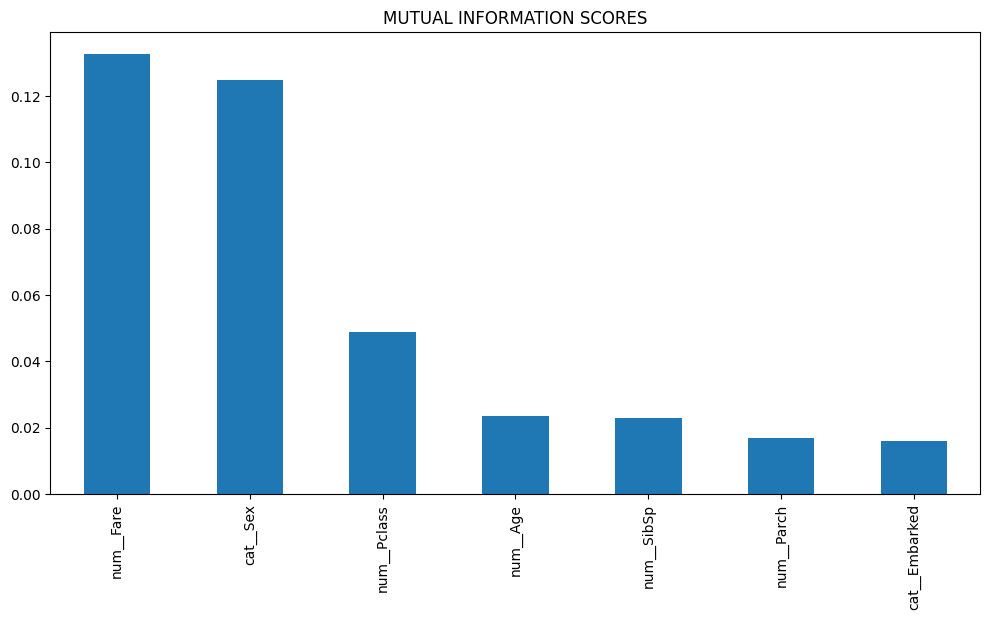

In [21]:
mi.plot(kind='bar', title='MUTUAL INFORMATION SCORES', figsize=(12, 6))

SELECTING TOP 5 FEATURE

In [22]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(mutual_info_classif, k=5)
sel.fit(x_pre, y)
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__Pclass', 'num__Parch', 'num__Fare', 'cat__Sex',
       'cat__Embarked'], dtype=object)

GETTING ORIGINAL COLUMN NAMES

In [23]:
sel_cols[0].split('__')

['num', 'Pclass']

In [24]:
sel_cols[0].split('__')[1]

'Pclass'

In [25]:
imp_cols = []
for i in sel_cols:
    s = i.split('__')[1]
    imp_cols.append(s)

In [26]:
imp_cols

['Pclass', 'Parch', 'Fare', 'Sex', 'Embarked']

In [27]:
x_imp = x[imp_cols]
x_imp

,Pclass,Parch,Fare,Sex,Embarked
0,3,0,7.2500,male,S
1,1,0,71.2833,female,C
2,3,0,7.9250,female,S
3,1,0,53.1000,female,S
4,3,0,8.0500,male,S
...,...,...,...,...,...
886,2,0,13.0000,male,S
887,1,0,30.0000,female,S
888,3,2,23.4500,female,S
889,1,0,30.0000,male,C


SEPERATING CAT AND CON FOR SELECTED COLUMNS

In [28]:
cat_sel = list(x_imp.columns[x_imp.dtypes=='object'])
con_sel = list(x_imp.columns[x_imp.dtypes!='object'])

In [29]:
cat_sel

['Sex', 'Embarked']

In [30]:
con_sel

['Pclass', 'Parch', 'Fare']

CREATING A FINAL PREPROCESSING PIPELINE

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [32]:
num_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler',StandardScaler())])

In [33]:
cat_pipe2 = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [34]:
pre2 = ColumnTransformer([('num',num_pipe2, con_sel),
                          ('cat', cat_pipe2, cat_sel)]).set_output(transform='pandas')

In [35]:
x_sel_pre = pre2.fit_transform(x_imp)
x_sel_pre.head()

,num__Pclass,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0
1,-1.566107,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0
2,0.827377,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0
3,-1.566107,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0
4,0.827377,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0


APPLYING TRAIN TEST SPLIT FOR X_SEL_PRE

In [36]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x_sel_pre, y, test_size=0.2, random_state=21)

In [37]:
xtrain.shape

(712, 8)

In [38]:
xtest.shape

(179, 8)

CREATING A LOGISTIC REGRESSION MODEL

In [39]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(xtrain, ytrain)

LogisticRegression()

In [40]:
model.score(xtrain, ytrain)

0.7921348314606742

In [41]:
model.score(xtest, ytest)

0.770949720670391

PREDICT RESULTS FOR TRAIN AND TEST

In [42]:
ypred_tr = model.predict(xtrain)
ypred_ts = model.predict(xtest)

In [43]:
ypred_tr[0:5]

array([1, 0, 0, 1, 0], dtype=int64)

In [44]:
ytrain.head()

,Survived
793,0
23,1
97,1
9,1
157,0


In [45]:
ytest.head()

,Survived
617,0
379,0
725,0
826,0
450,0


In [46]:
ypred_ts[0:5]

array([1, 0, 0, 0, 0], dtype=int64)

CREATING A CONFUSION MATRIX

In [47]:
c = model.classes_
c

array([0, 1], dtype=int64)

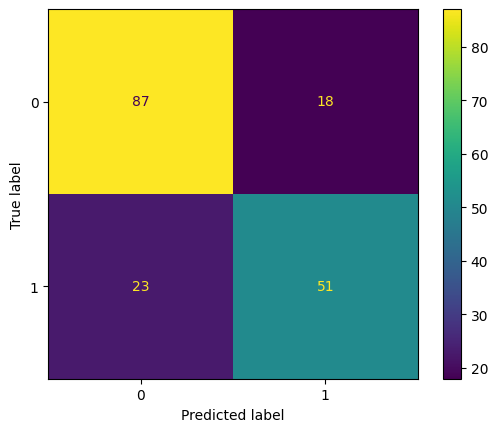

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(ytest, ypred_ts)
cfd = ConfusionMatrixDisplay(cf, display_labels=c)
cfd.plot()

CLASSIFICATION REPORT

In [49]:
from sklearn.metrics import classification_report
print (classification_report(ytest, ypred_ts))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       105
           1       0.74      0.69      0.71        74

    accuracy                           0.77       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



PREDICTING RESULTS FOR OUT OF SAMPLE DATA

In [50]:
xnew = pd.read_csv('test_titanic.csv')
xnew.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [51]:
pre2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Pclass', 'Parch', 'Fare']),
                                ('cat',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Sex', 'Embarked'])])

APPLYING PRE.TRANSFORM ON OUT OF SAMPLE DATA

In [52]:
xnew_pre = pre2.transform(xnew)
xnew_pre.head()

,num__Pclass,num__Parch,num__Fare,cat__Sex_female,cat__Sex_male,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,0.827377,-0.473674,-0.490783,0.0,1.0,0.0,1.0,0.0
1,0.827377,-0.473674,-0.507479,1.0,0.0,0.0,0.0,1.0
2,-0.369365,-0.473674,-0.453367,0.0,1.0,0.0,1.0,0.0
3,0.827377,-0.473674,-0.474005,0.0,1.0,0.0,0.0,1.0
4,0.827377,0.767630,-0.401017,1.0,0.0,0.0,0.0,1.0


PREDICTING THE RESULTS AND PROBABILITY

In [53]:
preds = model.predict(xnew_pre)
preds

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [54]:
model.classes_

array([0, 1], dtype=int64)

In [55]:
prob = model.predict_proba(xnew_pre)[:,1]
prob[0:5]

array([0.12277194, 0.59417436, 0.2495532 , 0.09399518, 0.55577404])

SAVING ABOVE IN DATAFRAME

In [56]:
df_final = xnew[['PassengerId']]
df_final

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [57]:
df_final['Survived_pred']=preds
df_final['Survived_prob']=prob

In [58]:
df_final

,PassengerId,Survived_pred,Survived_prob
0,892,0,0.122772
1,893,1,0.594174
2,894,0,0.249553
3,895,0,0.093995
4,896,1,0.555774
...,...,...,...
413,1305,0,0.093959
414,1306,1,0.938764
415,1307,0,0.093911
416,1308,0,0.093959


SAVING ABOE RESULTS TO CSV

In [59]:
df_final.to_csv('results.csv', index=False)

PLOTTING HOW MANY PEOPLE SURVIVED

In [60]:
df_final['Survived_pred'].value_counts()

Survived_pred
0    247
1    171
Name: count, dtype: int64

<Axes: xlabel='Survived_pred'>

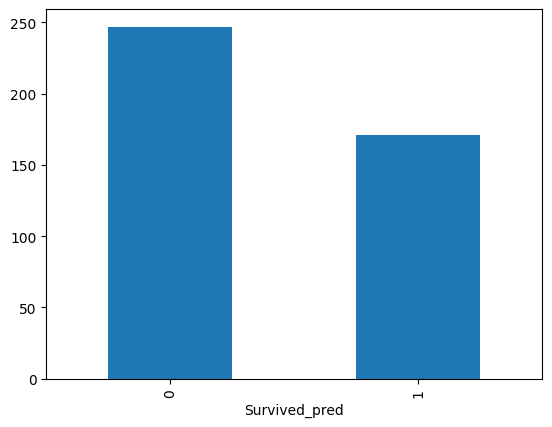

In [61]:
df_final['Survived_pred'].value_counts().plot(kind='bar')